[nltk_data] Downloading package punkt to /Users/ashwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is n

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sk

Accuracy: 0.8416666666666667
Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.84      0.90       118
        fear       0.94      0.81      0.87        99
         joy       0.72      0.76      0.74        96
        love       0.90      0.93      0.92       101
     sadness       0.67      0.73      0.69        91
    surprise       0.86      0.98      0.92        95

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600



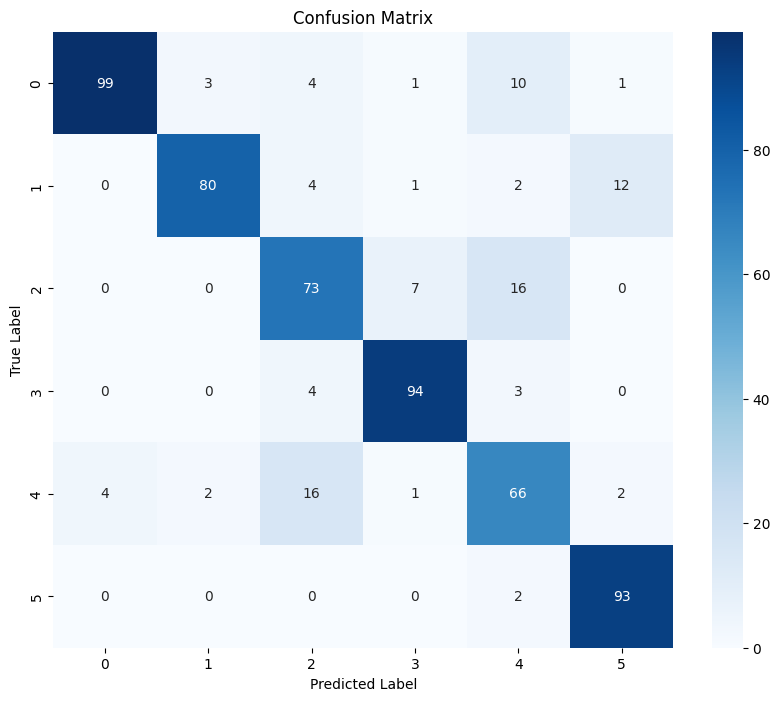

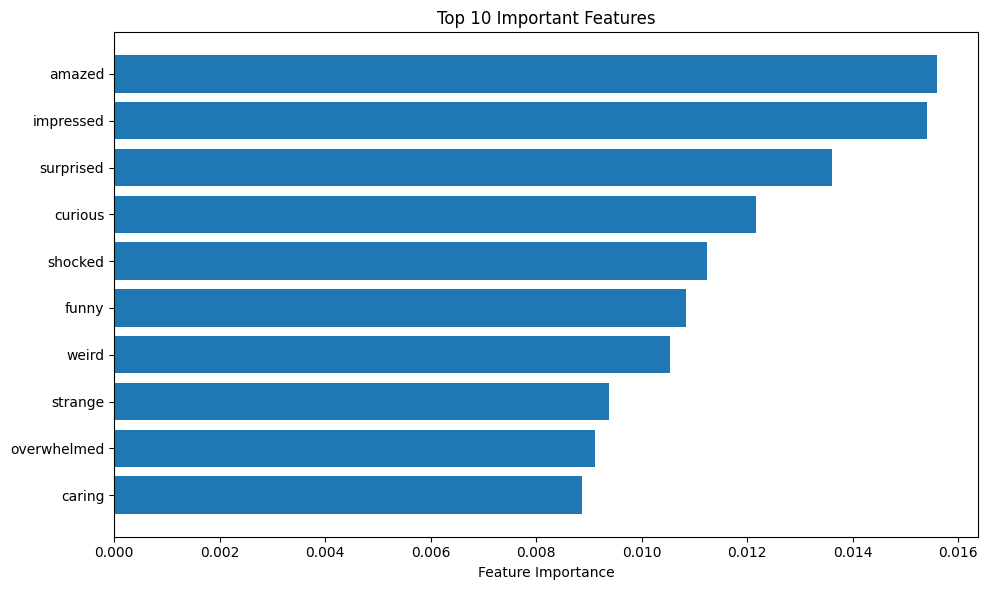

Text: I am so excited about the upcoming vacation!
Predicted Emotion: joy

Text: I feel completely overwhelmed with work right now.
Predicted Emotion: surprise

Text: The kids are really making me angry today.
Predicted Emotion: anger



In [2]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords once
stop_words = set(stopwords.words('english'))

# Custom tokenizer
def custom_tokenizer(text, stop_words=stop_words):
    tokens = word_tokenize(text.lower())
    return [token for token in tokens if token.isalnum() and token not in stop_words]

def tokenizer(text):
    return custom_tokenizer(text)

# Load dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('count', CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'count__max_features': [5000, 10000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
model = grid_search.best_estimator_

# Save the model to a .pkl file
file_name = '../trained_models/RF_CV.pkl'
joblib.dump(model, file_name)

# Load the model from a .pkl file
loaded_model = joblib.load(file_name)

# Predict on the test set
y_pred = loaded_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_names = loaded_model.named_steps['count'].get_feature_names_out()
feature_importance = loaded_model.named_steps['clf'].feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10_features = sorted_idx[-10:]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features")
plt.barh(range(10), feature_importance[top_10_features])
plt.yticks(range(10), [feature_names[i] for i in top_10_features])
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Predict emotions for the new examples
predictions = loaded_model.predict(new_examples)

# Output predictions
for example, prediction in zip(new_examples, predictions):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {prediction}")
    print()
